In [10]:
import pde_nn.channel_flow as chan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [19]:
# overall hypers
hypers = chan.get_hyperparams(ymin=-1, ymax=1, num_epochs=200, lr=0.0001, 
                              num_layers=4, num_units=40, batch_size=1000)
delta = (hypers['ymax']-hypers['ymin'])/2

## Numerically calculating the solution

In [20]:
reynolds_stress_fn = lambda y, du_dy: -1*((hypers['k']*(np.abs(y)-delta))**2)*np.abs(du_dy)*du_dy
diffeq = lambda du2_dy2, dre_dy: hypers['nu']*du2_dy2 - dre_dy - (1/hypers['rho']) * hypers['dp_dx']

In [21]:
n=1200
y = np.linspace(-1, 1, n)
delta_y = y[1] - y[0]
u_bar = 0.5*np.ones(n)

In [34]:
from scipy.optimize import least_squares, root

def diffeq_fn(u):
    u[0],u[-1]=0,0
    du_dy = np.gradient(u, delta_y, edge_order=2)
    dre_dy = np.gradient(reynolds_stress_fn(y, du_dy), delta_y, edge_order=2)
    du2_dy2 = np.gradient(du_dy, delta_y, edge_order=2)
    return diffeq(du2_dy2, dre_dy)

def compute_numerical(diffeq_fn, u_bar):
    u_star = least_squares(diffeq_fn, u_bar)
#     u_star = root(diffeq_fn, u_bar)
    return u_star.x

In [35]:
hypers['nu']=0.00555555
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Calculating at Retau={}'.format(retau))

u_star = compute_numerical(diffeq_fn, u_bar)

Calculating at Retau=180.00018000018


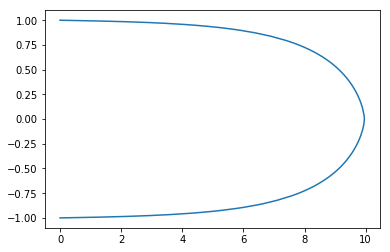

In [37]:
plt.plot(u_star, y)

## Retau 180 with DNS params

In [38]:
# hypers['nu']=0.005492
hypers['nu']=3.50000e-04
# u_tau = 6.37309e-02
# tau_w = -1 * hypers['dp_dx']
hypers['rho'] = 1/((6.37309e-02)**2)

retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Calculating at Retau={}'.format(retau))

u_star = compute_numerical(diffeq_fn, u_bar)

Calculating at Retau=182.0882857142857


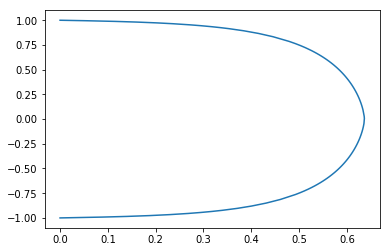

In [39]:
plt.plot(u_star, y)

In [37]:
np.max(u_star), np.max(np.load('data/mixlen_numerical_u180.npy'))

(9.961424662241415, 9.961424662274926)

In [16]:
np.save('data/mixlen_numerical_u180.npy', u_star)

## Retau 550

In [17]:
hypers['nu']=0.001818181818
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Calculating at Retau={}'.format(retau))
u_star = compute_numerical(diffeq_fn, u_bar)

Calculating at Retau=550.000000055


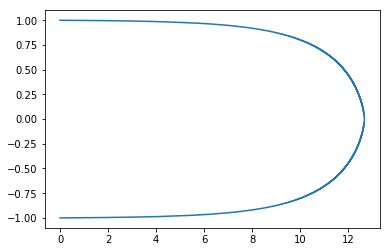

In [18]:
plt.plot(u_star, y)

In [19]:
np.save('data/mixlen_numerical_u550.npy', u_star)

## Retau 1000

In [20]:
hypers['nu']=0.001
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Calculating at Retau={}'.format(retau))
u_star = compute_numerical(diffeq_fn, u_bar)

Calculating at Retau=1000.0


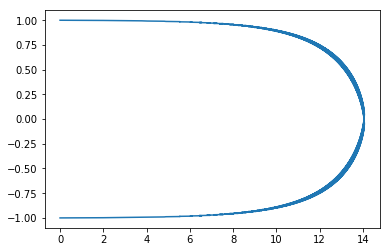

In [21]:
plt.plot(u_star, y)

In [22]:
np.save('data/mixlen_numerical_u1000.npy', u_star)

## Plot non-dimensionalized sol'n

In [94]:
def convert_dns(delta, hypers, dns):
    tau_w = -delta * hypers['dp_dx']
    u_tau = np.sqrt(tau_w / hypers['rho'])
    h_v = hypers['nu'] / u_tau
    half_y = dns[['y+,']]*h_v
    half_u = dns[['u_1,']]
    # full_u = np.concatenate([half_u, half_u], axis=0)
    # full_y = np.concatenate([half_y, -half_y+2*delta], axis=0)
    return half_u,  half_y

In [95]:
hypers = chan.get_hyperparams(ymin=-1, ymax=1, num_epochs=200000, lr=0.0001, 
                              num_layers=4, num_units=40, batch_size=2000)

In [96]:
hypers['nu']=0.005555555555
delta = (hypers['ymax']-hypers['ymin'])/2
reynolds_stress = chan.get_mixing_len_model(hypers['k'], delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Training at Retau={}'.format(retau))

Training at Retau=180.000000018


In [122]:
numerical_u = np.load('data/mixing_length_numerical_Retau180.npy')[:500]

In [121]:
pdenn_preds = np.load('data/preds_retau180_200k_epochs_2k_batchsize.npy')[:500]

In [124]:
y=y[:500]

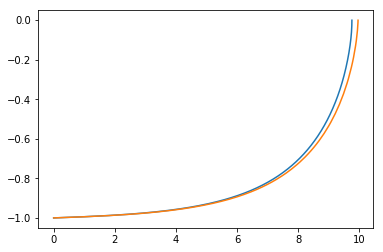

In [125]:
plt.plot(pdenn_preds, y)
plt.plot(numerical_u ,y)

In [126]:
tau_w = -delta * hypers['dp_dx']
u_tau = np.sqrt(tau_w / hypers['rho'])
h_v = hypers['nu'] / u_tau

In [127]:
dns_retau180 = pd.read_csv('data/LM_Channel_Retau180.txt', delimiter=' ')

In [145]:
dns_utau = 6.37309e-02

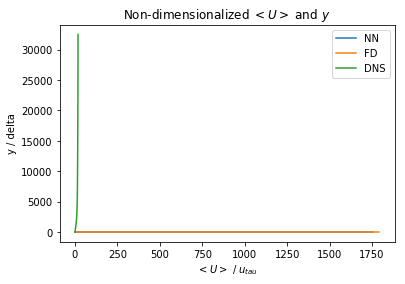

In [150]:
plt.plot(pdenn_preds/h_v, y/delta, label='NN')
plt.plot(numerical_u/h_v, y/delta, label='FD')
plt.plot(dns_retau180[['u_1,']], dns_retau180[['y+,']]/h_v, label='DNS')
plt.legend()
plt.title('Non-dimensionalized $<U>$ and $y$')
plt.xlabel('$<U>$ / $u_{tau}$')
plt.ylabel('y / delta')
plt.show()